In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Goiás - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_GO.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Goiás - Produção de Cimento (t),Goiás - Consumo de Cimento (t),Goiás - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego
0,2003-1,56.459960,97.447,0.745293,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.260097,9.371822e+07,5.518325e+06,14.031270,8.418248e+07,8.179785
1,2003-2,56.789152,97.256,0.745405,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.258964,9.383590e+07,5.523290e+06,14.034476,8.422082e+07,8.174086
2,2003-3,57.140263,101.442,0.745517,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.257352,9.395358e+07,5.528254e+06,14.037682,8.425916e+07,8.168386
3,2003-4,57.649192,98.217,0.745629,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.255929,9.407126e+07,5.533219e+06,14.040888,8.429750e+07,8.162687
4,2003-5,58.213295,112.540,0.745741,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.254109,9.418894e+07,5.538184e+06,14.044093,8.433584e+07,8.156988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,175.674487,274.673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.520178,NaN,NaN,NaN,NaN,NaN
236,2022-9,174.614843,247.240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.518515,NaN,NaN,NaN,NaN,NaN
237,2022-10,173.307223,246.647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.516447,NaN,NaN,NaN,NaN,NaN
238,2022-11,171.556538,225.813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.513912,NaN,NaN,NaN,NaN,NaN


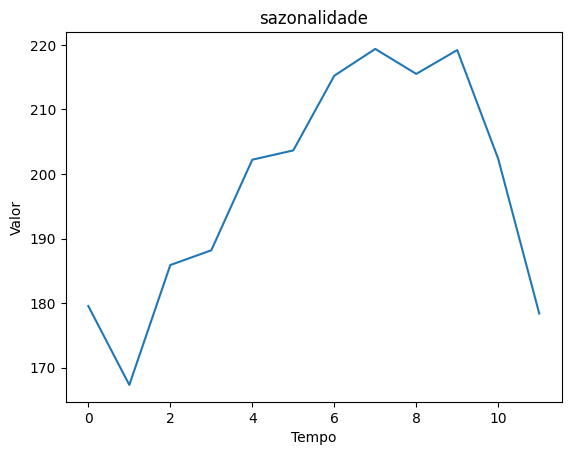

,sazonalidade
sazonalidade,
0,179.530071
1,167.306929
2,185.889857
3,188.176071
4,202.218071
5,203.657071
6,215.235143
7,219.389000
8,215.517929


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Goiás - Produção de Cimento (t),Goiás - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - PIB - Per Capita,Goiás - PIB - Preços de Mercado,Goiás - Desemprego,sazonalidade,Goiás - Consumo de Cimento (t)
0,2003-1,56.459960,0.745293,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.260097,9.371822e+07,5.518325e+06,14.031270,8.418248e+07,8.179785,179.530071,97.447
1,2003-2,56.789152,0.745405,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.258964,9.383590e+07,5.523290e+06,14.034476,8.422082e+07,8.174086,167.306929,97.256
2,2003-3,57.140263,0.745517,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.257352,9.395358e+07,5.528254e+06,14.037682,8.425916e+07,8.168386,185.889857,101.442
3,2003-4,57.649192,0.745629,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.255929,9.407126e+07,5.533219e+06,14.040888,8.429750e+07,8.162687,188.176071,98.217
4,2003-5,58.213295,0.745741,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.254109,9.418894e+07,5.538184e+06,14.044093,8.433584e+07,8.156988,202.218071,112.540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,175.674487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.520178,NaN,NaN,NaN,NaN,NaN,219.389000,274.673
236,2022-9,174.614843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.518515,NaN,NaN,NaN,NaN,NaN,215.517929,247.240
237,2022-10,173.307223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.516447,NaN,NaN,NaN,NaN,NaN,219.208286,246.647
238,2022-11,171.556538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.513912,NaN,NaN,NaN,NaN,NaN,202.338714,225.813


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      121.831
1      115.210
2      122.721
3      130.262
4      139.268
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: Goiás - Consumo de Cimento (t), Length: 240, dtype: float64

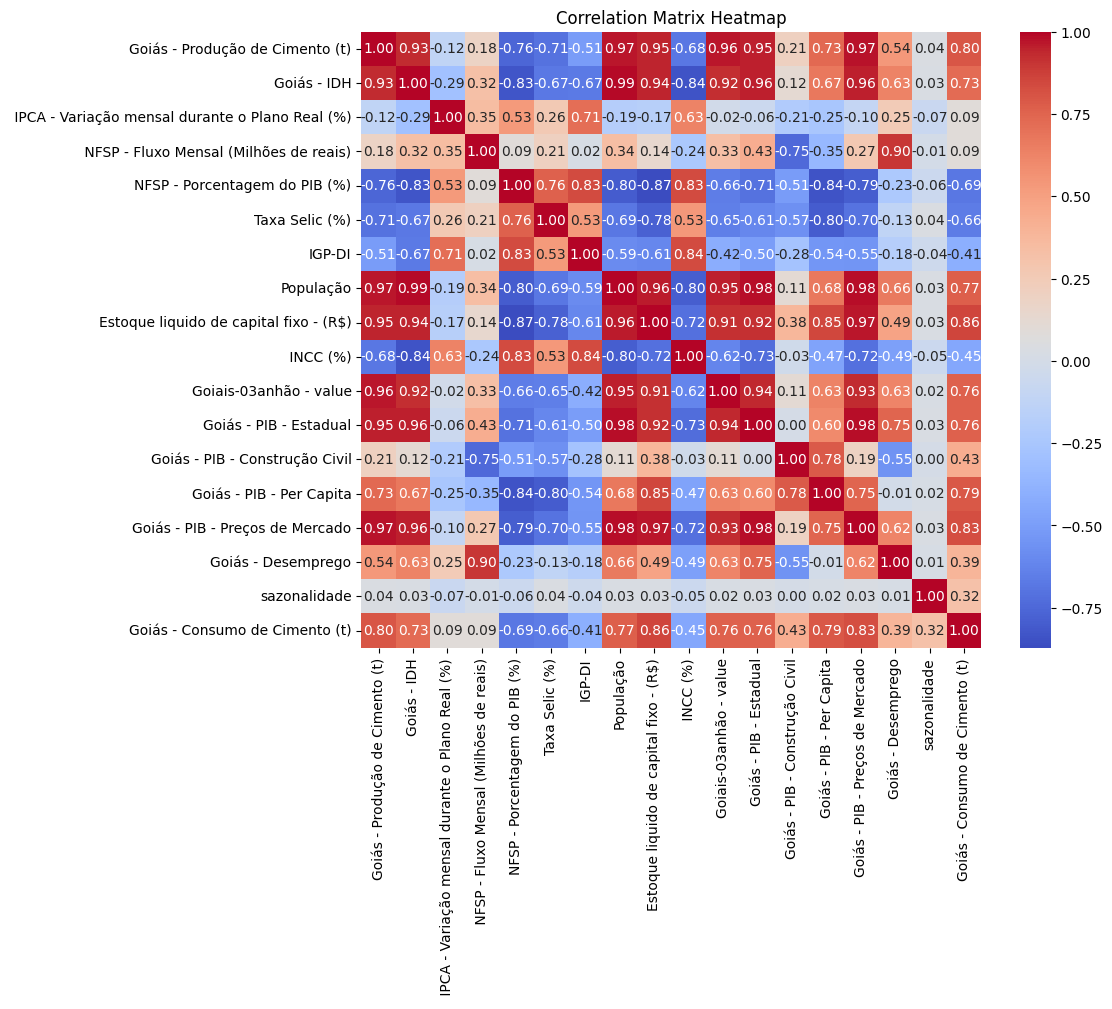

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Goiás - Produção de Cimento (t),1.172169e+04
1,Goiás - IDH,5.271685e+06
2,IPCA - Variação mensal durante o Plano Real (%),2.055307e+03
3,NFSP - Fluxo Mensal (Milhões de reais),3.858086e+02
4,NFSP - Porcentagem do PIB (%),2.570331e+02
5,Taxa Selic (%),5.837464e+01
6,IGP-DI,3.443071e+02
7,População,2.130966e+06
8,Estoque liquido de capital fixo - (R$),4.230783e+06
9,INCC (%),1.427365e+03


In [39]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 4


,Goiás - Produção de Cimento (t),Goiás - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - Desemprego,sazonalidade
0,56.459960,0.745293,0.724032,-5331.049150,11.520143,1.639718,1.036534,0.969649,0.260097,9.371822e+07,5.518325e+06,8.179785,179.530071
1,56.789152,0.745405,0.690297,-5318.079644,11.189862,1.378899,0.993449,0.950783,0.258964,9.383590e+07,5.523290e+06,8.174086,167.306929
2,57.140263,0.745517,0.669681,-5436.417870,10.820792,1.924317,0.973020,0.938332,0.257352,9.395358e+07,5.528254e+06,8.168386,185.889857
3,57.649192,0.745629,0.660494,-5707.015274,10.417840,1.331174,0.940489,0.926401,0.255929,9.407126e+07,5.533219e+06,8.162687,188.176071
4,58.213295,0.745741,0.648337,-5599.317941,9.959690,1.736072,0.917493,0.951683,0.254109,9.418894e+07,5.538184e+06,8.156988,202.218071
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,134.807122,0.755073,0.366904,-5783.316460,2.206994,0.545067,0.471521,0.378150,0.374870,1.121784e+08,5.556824e+06,8.945274,219.389000
176,135.642275,0.755002,0.358935,-6001.730740,2.215328,0.782910,0.476827,0.377666,0.375507,1.121578e+08,5.556960e+06,8.940201,215.517929
177,136.782331,0.754931,0.354313,-6454.887704,2.232466,0.909682,0.475427,0.377838,0.376148,1.121371e+08,5.557097e+06,8.935128,219.208286
178,137.789488,0.754859,0.352728,-6243.191421,2.263185,1.050614,0.491301,0.370057,0.376801,1.121165e+08,5.557233e+06,8.930055,202.338714


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Goiás - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - Desemprego
0,-2.223031,2.802383,0.604311,4.268118,2.039314,3.921218,3.214079,-0.886364,-1.663692,-1.837162,-0.335191
1,-2.183889,2.402642,0.609431,4.096014,1.195209,3.582946,3.051841,-0.907289,-1.644951,-1.780760,-0.345766
2,-2.144748,2.158351,0.562720,3.903698,2.960381,3.422548,2.944772,-0.937020,-1.626210,-1.724357,-0.356341
3,-2.105606,2.049492,0.455907,3.693727,1.040752,3.167136,2.842174,-0.963285,-1.607469,-1.667955,-0.366915
4,-2.066465,1.905441,0.498418,3.454992,2.351150,2.986591,3.059587,-0.996868,-1.588728,-1.611553,-0.377490
...,...,...,...,...,...,...,...,...,...,...,...
175,1.198009,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,-1.872446,1.231466,1.276227,-1.399784,1.085145
176,1.173029,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,-1.876611,1.243232,1.272941,-1.398237,1.075731
177,1.148048,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,-1.875135,1.255063,1.269655,-1.396690,1.066318
178,1.123067,-1.597335,0.244264,-0.555524,0.132757,-0.359568,-1.942040,1.267112,1.266369,-1.395143,1.056905


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Goiás - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - Desemprego
0,-2.223031,2.802383,0.604311,4.268118,2.039314,3.921218,3.214079,-0.886364,-1.663692,-1.837162,-0.335191
1,-2.183889,2.402642,0.609431,4.096014,1.195209,3.582946,3.051841,-0.907289,-1.644951,-1.780760,-0.345766
2,-2.144748,2.158351,0.562720,3.903698,2.960381,3.422548,2.944772,-0.937020,-1.626210,-1.724357,-0.356341
3,-2.105606,2.049492,0.455907,3.693727,1.040752,3.167136,2.842174,-0.963285,-1.607469,-1.667955,-0.366915
4,-2.066465,1.905441,0.498418,3.454992,2.351150,2.986591,3.059587,-0.996868,-1.588728,-1.611553,-0.377490
...,...,...,...,...,...,...,...,...,...,...,...
163,1.475226,-0.960452,1.465326,-0.676734,0.472779,-1.087000,-1.491033,1.097275,1.284294,-1.325267,1.458473
164,1.454756,-1.007966,1.351131,-0.668750,0.302784,-0.904679,-1.525186,1.105888,1.287281,-1.342336,1.396986
165,1.434286,-0.976556,1.143146,-0.657609,0.339539,-0.900134,-1.546744,1.114449,1.290269,-1.359405,1.335498
166,1.413816,-1.146834,1.542609,-0.647588,0.472795,-1.136836,-1.586381,1.122956,1.293256,-1.376474,1.274011


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      121.831
1      115.210
2      122.721
3      130.262
4      139.268
        ...   
163    224.270
164    213.871
165    211.066
166    182.899
167    159.002
Name: Goiás - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 11)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Goiás - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Goiais-03anhão - value,Goiás - PIB - Estadual,Goiás - PIB - Construção Civil,Goiás - Desemprego
132,0.672573,1.530065,0.817451,-0.366715,-0.530011,0.174628,-0.066954,0.850601,1.023938,0.362477,1.215921
133,0.664244,1.649361,1.130195,-0.350285,-0.532694,0.240832,-0.130652,0.854655,1.036109,0.283781,1.275042
134,0.655915,1.622916,1.160498,-0.335122,-0.186421,0.176857,-0.079602,0.858521,1.048279,0.205086,1.334162
135,0.647586,1.581460,1.131990,-0.321950,-0.719664,-0.005233,-0.034473,0.866037,1.060449,0.126390,1.393282
136,0.639258,1.638292,1.384387,-0.302995,-0.798520,0.097576,-0.177535,0.873515,1.072620,0.047695,1.452403
137,0.630929,1.643773,1.375487,-0.290554,-0.612129,0.431487,-0.208868,0.881758,1.084790,-0.031001,1.511523
138,0.622600,1.704584,1.438928,-0.281926,-0.476740,0.482414,-0.245300,0.896585,1.096961,-0.109696,1.570643
139,0.614271,1.841703,1.569590,-0.275931,-0.211736,0.657043,-0.333490,0.907739,1.109131,-0.188392,1.629764
140,0.605942,1.837218,1.584058,-0.271466,-0.484608,0.678386,-0.296846,0.918912,1.121302,-0.267087,1.688884
141,0.597613,1.797860,1.166380,-0.273241,-0.183907,0.727143,-0.292462,0.930119,1.133472,-0.345783,1.748004


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 11)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3811085189, 3457131012, 2566021574, 1485621125, 3664173764, 3807740341, 2924643808, 723814392, 2613584781, 3748995259]


Step: 0 ___________________________________________
val_loss: 1016.3114624023438
winner_seed: 3811085189


Step: 1 ___________________________________________
val_loss: 1415.2843017578125


Step: 2 ___________________________________________
val_loss: 1366.68359375


Step: 3 ___________________________________________
val_loss: 1076.241943359375


Step: 4 ___________________________________________
val_loss: 1331.8642578125


Step: 5 ___________________________________________
val_loss: 1155.787109375


Step: 6 ___________________________________________
val_loss: 99311.4453125


Step: 7 ___________________________________________
val_loss: 1269.1878662109375


Step: 8 ___________________________________________
val_loss: 802.5804443359375
winner_seed: 2613584781


Step: 9 ___________________________________________
val_loss: 990.208984375


final_seed: 2613584781


In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 124ms/step - loss: 44115.2305 - val_loss: 3735.8420
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 5821.3335 - val_loss: 1197.4196
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 1617.3185 - val_loss: 2503.8730
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 1452.1213 - val_loss: 2459.5208
Epoch 5/10000
4/4 [==============================] - 0s 10ms/step - loss: 1437.3165 - val_loss: 2707.1985
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 1432.5874 - val_loss: 2531.0918
Epoch 7/10000
4/4 [==============================] - 0s 11ms/step - loss: 1322.4418 - val_loss: 1493.4366
Epoch 8/10000
4/4 [==============================] - 0s 11ms/step - loss: 1311.6663 - val_loss: 1520.3899
Epoch 9/10000
4/4 [==============================] - 0s 10ms/step - loss: 1284.0018 - val_loss: 1860.9664
Epoch 10/10000
4/4 [========================

Epoch 155/10000
4/4 [==============================] - 0s 10ms/step - loss: 581.0511 - val_loss: 1709.1780
Epoch 156/10000
4/4 [==============================] - 0s 10ms/step - loss: 561.8007 - val_loss: 1694.7086
Epoch 157/10000
4/4 [==============================] - 0s 11ms/step - loss: 541.6466 - val_loss: 1890.0314
Epoch 158/10000
4/4 [==============================] - 0s 11ms/step - loss: 573.3369 - val_loss: 1769.4513
Epoch 159/10000
4/4 [==============================] - 0s 11ms/step - loss: 606.1327 - val_loss: 2043.1799
Epoch 160/10000
4/4 [==============================] - 0s 10ms/step - loss: 576.5728 - val_loss: 1898.5084
Epoch 161/10000
4/4 [==============================] - 0s 10ms/step - loss: 576.2158 - val_loss: 1995.8987
Epoch 162/10000
4/4 [==============================] - 0s 10ms/step - loss: 568.8529 - val_loss: 2421.8462
Epoch 163/10000
4/4 [==============================] - 0s 10ms/step - loss: 574.2982 - val_loss: 2312.5364
Epoch 164/10000
4/4 [================

Epoch 308/10000
4/4 [==============================] - 0s 11ms/step - loss: 505.1499 - val_loss: 2086.7266
Epoch 309/10000
4/4 [==============================] - 0s 11ms/step - loss: 507.1122 - val_loss: 1965.4893
Epoch 310/10000
4/4 [==============================] - 0s 11ms/step - loss: 544.0790 - val_loss: 2022.4623
Epoch 311/10000
4/4 [==============================] - 0s 11ms/step - loss: 506.0340 - val_loss: 2074.5972
Epoch 312/10000
4/4 [==============================] - 0s 11ms/step - loss: 472.8235 - val_loss: 2047.7976
Epoch 313/10000
4/4 [==============================] - 0s 10ms/step - loss: 517.1057 - val_loss: 2141.1201
Epoch 314/10000
4/4 [==============================] - 0s 11ms/step - loss: 484.8259 - val_loss: 2027.6151
Epoch 315/10000
4/4 [==============================] - 0s 11ms/step - loss: 569.7838 - val_loss: 1950.6169
Epoch 316/10000
4/4 [==============================] - 0s 10ms/step - loss: 545.3275 - val_loss: 2084.2732
Epoch 317/10000
4/4 [================

4/4 [==============================] - 0s 9ms/step - loss: 490.7193 - val_loss: 1683.4998
Epoch 462/10000
4/4 [==============================] - 0s 9ms/step - loss: 494.5163 - val_loss: 1741.8533
Epoch 463/10000
4/4 [==============================] - 0s 10ms/step - loss: 521.9603 - val_loss: 1812.9310
Epoch 464/10000
4/4 [==============================] - 0s 9ms/step - loss: 553.7890 - val_loss: 1761.1007
Epoch 465/10000
4/4 [==============================] - 0s 10ms/step - loss: 497.3746 - val_loss: 1781.1523
Epoch 466/10000
4/4 [==============================] - 0s 10ms/step - loss: 589.2188 - val_loss: 1858.0029
Epoch 467/10000
4/4 [==============================] - 0s 11ms/step - loss: 504.0792 - val_loss: 1707.1047
Epoch 468/10000
4/4 [==============================] - 0s 11ms/step - loss: 483.5400 - val_loss: 1829.8524
Epoch 469/10000
4/4 [==============================] - 0s 11ms/step - loss: 509.9421 - val_loss: 1771.3275
Epoch 470/10000
4/4 [==============================] - 0

Epoch 538/10000
4/4 [==============================] - 0s 10ms/step - loss: 428.6497 - val_loss: 1568.1061
Epoch 539/10000
4/4 [==============================] - 0s 10ms/step - loss: 410.4949 - val_loss: 1585.9631
Epoch 540/10000
4/4 [==============================] - 0s 10ms/step - loss: 444.8008 - val_loss: 1638.4552
Epoch 541/10000
4/4 [==============================] - 0s 11ms/step - loss: 448.7306 - val_loss: 1504.2487
Epoch 542/10000
4/4 [==============================] - 0s 10ms/step - loss: 423.6984 - val_loss: 1621.8555
Epoch 543/10000
4/4 [==============================] - 0s 10ms/step - loss: 416.3219 - val_loss: 1561.4456
Epoch 544/10000
4/4 [==============================] - 0s 10ms/step - loss: 413.6163 - val_loss: 1625.1632
Epoch 545/10000
4/4 [==============================] - 0s 10ms/step - loss: 448.3636 - val_loss: 1629.2372
Epoch 546/10000
4/4 [==============================] - 0s 10ms/step - loss: 423.2196 - val_loss: 1553.3510
Epoch 547/10000
4/4 [================

4/4 [==============================] - 0s 10ms/step - loss: 403.0043 - val_loss: 1711.4729
Epoch 691/10000
4/4 [==============================] - 0s 11ms/step - loss: 441.1758 - val_loss: 1681.2062
Epoch 692/10000
4/4 [==============================] - 0s 10ms/step - loss: 546.2501 - val_loss: 1659.4095
Epoch 693/10000
4/4 [==============================] - 0s 10ms/step - loss: 426.9037 - val_loss: 1611.0153
Epoch 694/10000
4/4 [==============================] - 0s 11ms/step - loss: 433.5932 - val_loss: 1666.0748
Epoch 695/10000
4/4 [==============================] - 0s 11ms/step - loss: 372.2983 - val_loss: 1633.9205
Epoch 696/10000
4/4 [==============================] - 0s 10ms/step - loss: 393.2652 - val_loss: 1628.4286
Epoch 697/10000
4/4 [==============================] - 0s 10ms/step - loss: 394.7875 - val_loss: 1688.7227
Epoch 698/10000
4/4 [==============================] - 0s 11ms/step - loss: 397.3977 - val_loss: 1670.4056
Epoch 699/10000
4/4 [==============================] 

Epoch 767/10000
4/4 [==============================] - 0s 10ms/step - loss: 397.7354 - val_loss: 1457.8317
Epoch 768/10000
4/4 [==============================] - 0s 10ms/step - loss: 384.3940 - val_loss: 1562.9078
Epoch 769/10000
4/4 [==============================] - 0s 10ms/step - loss: 389.8456 - val_loss: 1624.5916
Epoch 770/10000
4/4 [==============================] - 0s 10ms/step - loss: 375.2396 - val_loss: 1585.4515
Epoch 771/10000
4/4 [==============================] - 0s 10ms/step - loss: 360.9155 - val_loss: 1613.3514
Epoch 772/10000
4/4 [==============================] - 0s 10ms/step - loss: 352.0417 - val_loss: 1552.7350
Epoch 773/10000
4/4 [==============================] - 0s 11ms/step - loss: 412.1101 - val_loss: 1618.8684
Epoch 774/10000
4/4 [==============================] - 0s 11ms/step - loss: 357.4829 - val_loss: 1543.3772
Epoch 775/10000
4/4 [==============================] - 0s 11ms/step - loss: 359.4487 - val_loss: 1527.9435
Epoch 776/10000
4/4 [================

Epoch 920/10000
4/4 [==============================] - 0s 10ms/step - loss: 306.2625 - val_loss: 1461.5565
Epoch 921/10000
4/4 [==============================] - 0s 8ms/step - loss: 284.6251 - val_loss: 1509.8694
Epoch 922/10000
4/4 [==============================] - 0s 9ms/step - loss: 293.7302 - val_loss: 1497.9254
Epoch 923/10000
4/4 [==============================] - 0s 9ms/step - loss: 297.8445 - val_loss: 1514.6755
Epoch 924/10000
4/4 [==============================] - 0s 9ms/step - loss: 335.9803 - val_loss: 1590.2799
Epoch 925/10000
4/4 [==============================] - 0s 9ms/step - loss: 331.7052 - val_loss: 1499.3217
Epoch 926/10000
4/4 [==============================] - 0s 10ms/step - loss: 334.9602 - val_loss: 1555.4220
Epoch 927/10000
4/4 [==============================] - 0s 10ms/step - loss: 305.5751 - val_loss: 1615.0382
Epoch 928/10000
4/4 [==============================] - 0s 10ms/step - loss: 314.1820 - val_loss: 1540.8597
Epoch 929/10000
4/4 [=====================

Epoch 997/10000
4/4 [==============================] - 0s 10ms/step - loss: 278.0332 - val_loss: 1530.1350
Epoch 998/10000
4/4 [==============================] - 0s 11ms/step - loss: 318.3629 - val_loss: 1482.7848
Epoch 999/10000
4/4 [==============================] - 0s 10ms/step - loss: 295.5308 - val_loss: 1562.2615
Epoch 1000/10000
4/4 [==============================] - 0s 10ms/step - loss: 303.8826 - val_loss: 1535.3525
Epoch 1001/10000
4/4 [==============================] - 0s 11ms/step - loss: 279.8715 - val_loss: 1560.8235
Epoch 1002/10000
4/4 [==============================] - 0s 11ms/step - loss: 282.8683 - val_loss: 1589.5225
Epoch 1003/10000
4/4 [==============================] - 0s 10ms/step - loss: 301.2053 - val_loss: 1564.8834
Epoch 1004/10000
4/4 [==============================] - 0s 10ms/step - loss: 304.0452 - val_loss: 3728.8743
Epoch 1005/10000
4/4 [==============================] - 0s 11ms/step - loss: 565.5086 - val_loss: 1001.3732
Epoch 1006/10000
4/4 [=========

4/4 [==============================] - 0s 11ms/step - loss: 321.5110 - val_loss: 1219.2487
Epoch 1150/10000
4/4 [==============================] - 0s 11ms/step - loss: 329.6307 - val_loss: 917.6924
Epoch 1151/10000
4/4 [==============================] - 0s 9ms/step - loss: 296.9126 - val_loss: 872.2946
Epoch 1152/10000
4/4 [==============================] - 0s 10ms/step - loss: 438.5925 - val_loss: 1297.9574
Epoch 1153/10000
4/4 [==============================] - 0s 10ms/step - loss: 436.4739 - val_loss: 1200.3018
Epoch 1154/10000
4/4 [==============================] - 0s 10ms/step - loss: 328.5345 - val_loss: 1054.8853
Epoch 1155/10000
4/4 [==============================] - 0s 10ms/step - loss: 310.0886 - val_loss: 1261.5281
Epoch 1156/10000
4/4 [==============================] - 0s 10ms/step - loss: 326.2356 - val_loss: 1088.3326
Epoch 1157/10000
4/4 [==============================] - 0s 10ms/step - loss: 294.2842 - val_loss: 1059.5421
Epoch 1158/10000
4/4 [==========================

4/4 [==============================] - 0s 10ms/step - loss: 219.9306 - val_loss: 1297.6169
Epoch 1226/10000
4/4 [==============================] - 0s 11ms/step - loss: 218.9104 - val_loss: 1229.5315
Epoch 1227/10000
4/4 [==============================] - 0s 11ms/step - loss: 239.3047 - val_loss: 1297.0504
Epoch 1228/10000
4/4 [==============================] - 0s 10ms/step - loss: 238.8488 - val_loss: 1360.9875
Epoch 1229/10000
4/4 [==============================] - 0s 10ms/step - loss: 245.7690 - val_loss: 1324.3622
Epoch 1230/10000
4/4 [==============================] - 0s 10ms/step - loss: 269.0763 - val_loss: 1136.4941
Epoch 1231/10000
4/4 [==============================] - 0s 11ms/step - loss: 246.6494 - val_loss: 1194.1632
Epoch 1232/10000
4/4 [==============================] - 0s 10ms/step - loss: 262.0702 - val_loss: 1129.0210
Epoch 1233/10000
4/4 [==============================] - 0s 11ms/step - loss: 242.5988 - val_loss: 1189.4424
Epoch 1234/10000
4/4 [=======================

4/4 [==============================] - 0s 11ms/step - loss: 306.4133 - val_loss: 1347.1805
Epoch 1302/10000
4/4 [==============================] - 0s 10ms/step - loss: 274.0799 - val_loss: 1270.7473
Epoch 1303/10000
4/4 [==============================] - 0s 10ms/step - loss: 246.1098 - val_loss: 1396.7595
Epoch 1304/10000
4/4 [==============================] - 0s 11ms/step - loss: 231.2989 - val_loss: 1364.7205
Epoch 1305/10000
4/4 [==============================] - 0s 10ms/step - loss: 213.7982 - val_loss: 1350.4521
Epoch 1306/10000
4/4 [==============================] - 0s 12ms/step - loss: 248.3891 - val_loss: 1308.7799
Epoch 1307/10000
4/4 [==============================] - 0s 11ms/step - loss: 231.4677 - val_loss: 1305.7631
Epoch 1308/10000
4/4 [==============================] - 0s 10ms/step - loss: 244.6939 - val_loss: 1314.5593
Epoch 1309/10000
4/4 [==============================] - 0s 10ms/step - loss: 226.8591 - val_loss: 1273.1810
Epoch 1310/10000
4/4 [=======================

4/4 [==============================] - 0s 11ms/step - loss: 236.4911 - val_loss: 1272.3604
Epoch 1378/10000
4/4 [==============================] - 0s 10ms/step - loss: 189.3849 - val_loss: 1315.7963
Epoch 1379/10000
4/4 [==============================] - 0s 11ms/step - loss: 227.5916 - val_loss: 1321.9852
Epoch 1380/10000
4/4 [==============================] - 0s 10ms/step - loss: 207.4719 - val_loss: 1241.7089
Epoch 1381/10000
4/4 [==============================] - 0s 11ms/step - loss: 234.9004 - val_loss: 1328.8357
Epoch 1382/10000
4/4 [==============================] - 0s 11ms/step - loss: 247.1727 - val_loss: 1359.8705
Epoch 1383/10000
4/4 [==============================] - 0s 11ms/step - loss: 228.8462 - val_loss: 1285.5035
Epoch 1384/10000
4/4 [==============================] - 0s 12ms/step - loss: 218.0095 - val_loss: 1333.7643
Epoch 1385/10000
4/4 [==============================] - 0s 11ms/step - loss: 219.5084 - val_loss: 1350.1754
Epoch 1386/10000
4/4 [=======================

4/4 [==============================] - 0s 11ms/step - loss: 171.3400 - val_loss: 1320.5918
Epoch 1454/10000
4/4 [==============================] - 0s 11ms/step - loss: 194.9571 - val_loss: 1344.8541
Epoch 1455/10000
4/4 [==============================] - 0s 11ms/step - loss: 171.5350 - val_loss: 1322.9111
Epoch 1456/10000
4/4 [==============================] - 0s 10ms/step - loss: 174.0852 - val_loss: 1330.3942
Epoch 1457/10000
4/4 [==============================] - 0s 10ms/step - loss: 172.5607 - val_loss: 1332.8533
Epoch 1458/10000
4/4 [==============================] - 0s 11ms/step - loss: 185.5939 - val_loss: 1178.7061
Epoch 1459/10000
4/4 [==============================] - 0s 11ms/step - loss: 206.3830 - val_loss: 1289.1799
Epoch 1460/10000
4/4 [==============================] - 0s 10ms/step - loss: 176.3334 - val_loss: 1315.8215
Epoch 1461/10000
4/4 [==============================] - 0s 11ms/step - loss: 190.2387 - val_loss: 1281.0000
Epoch 1462/10000
4/4 [=======================

4/4 [==============================] - 0s 11ms/step - loss: 167.7142 - val_loss: 1344.9010
Epoch 1530/10000
4/4 [==============================] - 0s 11ms/step - loss: 156.6486 - val_loss: 1294.4271
Epoch 1531/10000
4/4 [==============================] - 0s 11ms/step - loss: 151.2603 - val_loss: 1317.3458
Epoch 1532/10000
4/4 [==============================] - 0s 14ms/step - loss: 153.2505 - val_loss: 1260.3522
Epoch 1532: early stopping


In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,188.897842,191.36058,190.861725,191.553131,192.602463,191.629074,194.579239,192.625519,196.398788,201.075653,207.939407,212.16687
Target,178.918,161.936,173.792,176.627,207.991,185.784,234.176,226.996,218.141,234.939,199.619,168.797
Error,9.979843,29.424576,17.069717,14.926132,15.388535,5.845078,39.596756,34.370483,21.742218,33.863342,8.320404,43.369873


In [54]:
display(mae)
display(mape)

22.824747

0.11571548

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input.iloc[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             test_input, 
                                             test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

NameError: name 'test_target' is not defined